In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

import torch
from torch.nn import CrossEntropyLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from util import test_loss_Unet, train_U_NET, plot_loss, plot_acc, inference_time

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 4
image_size = (256, 256)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.CenterCrop(image_size)])

target_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(0.007843137718737125, 0.003921568393707275),transforms.CenterCrop(image_size), 
    transforms.Normalize(-1, 1)])

train_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="trainval", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="test", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

input_shape = (batch_size, 3, image_size[0], image_size[1])

In [4]:
uniq = []
for img in train_dataset:
    uniq.extend(torch.unique(img[1]).numpy())
    uniq = np.unique(uniq).tolist()
    break
#uniq = np.array(uniq).astype(int)
print(uniq)

[-1.1920928955078125e-07, 1.0, 2.0]


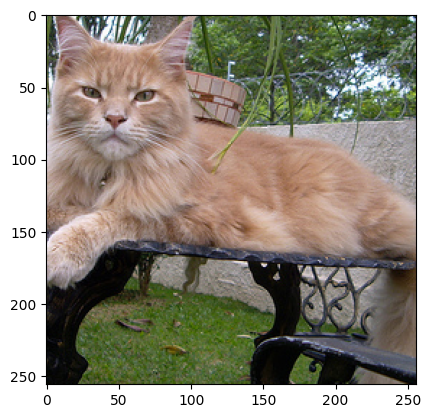

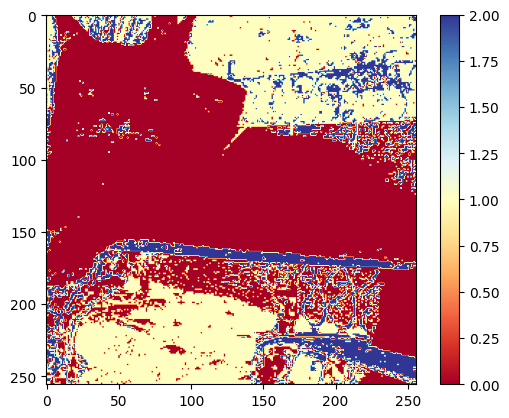

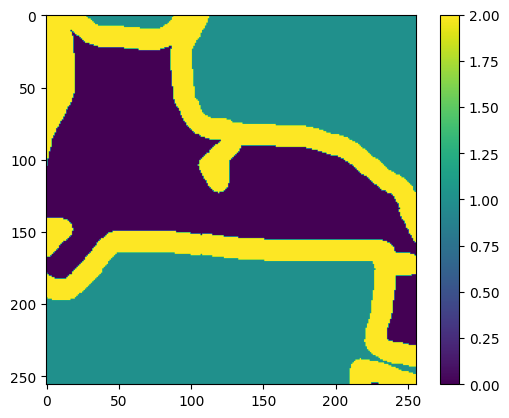

tensor(-1.1921e-07)


In [5]:
#print(train_dataset[2][0].shape)
img = torch.transpose(train_dataset[1000][0], 2,0)
img = torch.transpose(img, 1,0)
plt.imshow(img)
plt.show()

img_max = torch.argmax(train_dataset[1000][0], 0)
#img_max = torch.transpose(img_max, 2,0)
#img_max = torch.argmax(img_max, 2)
plt.imshow(img_max, cmap="RdYlBu")
plt.colorbar()
plt.show()

seg = torch.transpose(train_dataset[1000][1], 2,0)
seg = torch.transpose(seg, 1,0)
plt.imshow(seg)
plt.colorbar()
plt.show()
print(torch.min(seg))

In [4]:
from Models import U_Net

U_NN = U_Net(input_shape, output_channels=3, initial_lr=0.01, momentum=0.9, weight_decay=0)

summary(U_NN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
U_Net                                    [4, 3, 256, 256]          --
├─ModuleDict: 1-1                        --                        --
│    └─Sequential: 2-1                   [4, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                  [4, 64, 256, 256]         1,792
│    │    └─ReLU: 3-2                    [4, 64, 256, 256]         --
│    │    └─BatchNorm2d: 3-3             [4, 64, 256, 256]         128
│    │    └─Conv2d: 3-4                  [4, 64, 256, 256]         36,928
│    │    └─ReLU: 3-5                    [4, 64, 256, 256]         --
│    │    └─BatchNorm2d: 3-6             [4, 64, 256, 256]         128
│    └─MaxPool2d: 2-2                    [4, 64, 128, 128]         --
│    └─Sequential: 2-3                   [4, 128, 128, 128]        --
│    │    └─Conv2d: 3-7                  [4, 128, 128, 128]        73,856
│    │    └─ReLU: 3-8                    [4, 128, 128, 128]        --
│ 

In [5]:
PATH = "./models/U_Net/U_NN.pth"

if exists(PATH):
    U_NN = torch.load(PATH)
    U_NN.eval()

In [7]:
criterion = CrossEntropyLoss()
epochs = 10


train_U_NET(U_NN, criterion=criterion, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
        epochs=epochs, batches_to_test=300, patience=5, device=device, print_test=True, verbose=False, p_randomTransform=0.6)

[1,   300] train_loss: 0.263
test_loss: 0.377, test_accuracy: 86.26136589050293
[1,   600] train_loss: 0.266
test_loss: 0.390, test_accuracy: 86.06822776794434
[1,   900] train_loss: 0.267
test_loss: 0.370, test_accuracy: 86.14368629455566
[2,   280] train_loss: 0.250
test_loss: 0.398, test_accuracy: 85.86004829406738
[2,   580] train_loss: 0.263
test_loss: 0.381, test_accuracy: 85.91747283935547
[2,   880] train_loss: 0.272
test_loss: 0.377, test_accuracy: 85.89444732666016
[3,   260] train_loss: 0.230
test_loss: 0.372, test_accuracy: 86.34525871276855
[3,   560] train_loss: 0.257
test_loss: 0.378, test_accuracy: 85.93686485290527
[3,   860] train_loss: 0.254
test_loss: 0.368, test_accuracy: 86.31085014343262
[4,   240] train_loss: 0.201
test_loss: 0.378, test_accuracy: 86.13365745544434
[4,   540] train_loss: 0.255
test_loss: 0.397, test_accuracy: 85.61957550048828
[4,   840] train_loss: 0.261
test_loss: 0.375, test_accuracy: 85.86396217346191
[5,   220] train_loss: 0.189
test_loss: 

In [8]:
torch.save(U_NN, "./models/U_Net/U_NN.pth")

In [5]:
U_NN = torch.load("./models/U_Net/U_NN.pth")

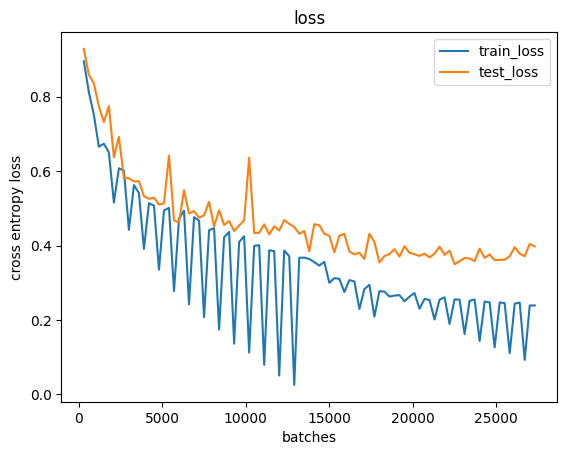

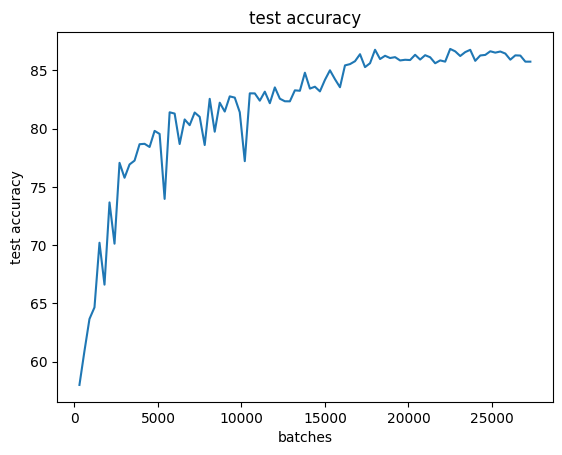

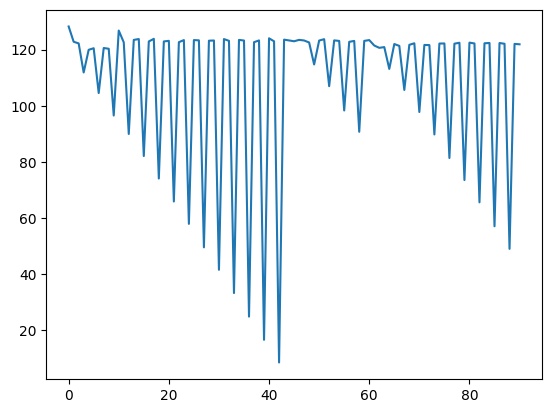

108.29756181318682


In [6]:
plot_loss(U_NN)
plot_acc(U_NN)

plt.plot(U_NN.train_time)
plt.show()
print(np.mean(U_NN.train_time))

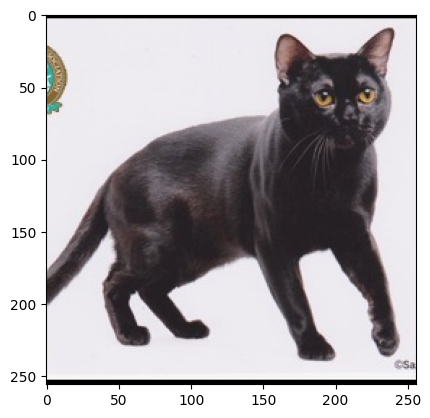

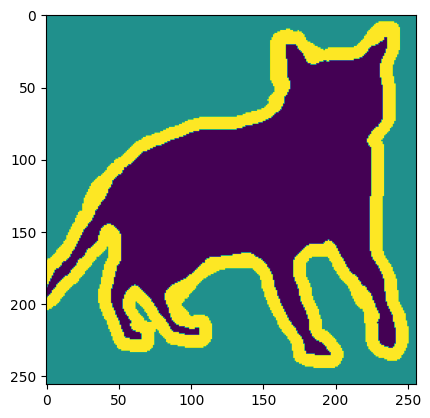

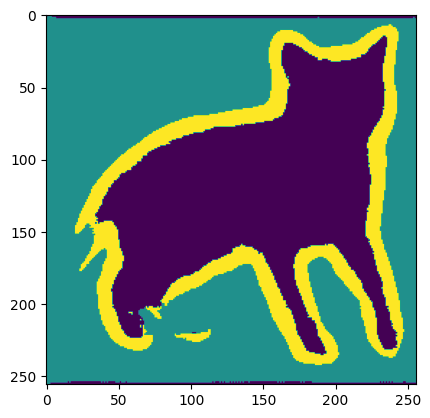

In [7]:
def show_segmentation_results(NN, dataset, index, device):
    img = torch.transpose(dataset[index][0], 2, 0)
    img = torch.transpose(img, 1,0)
    plt.imshow(img)
    plt.show()

    plt.imshow(dataset[index][1][0])
    plt.show()

    seg = dataset[index][0]
    seg = seg[None,:,:,:].to(device)
    outputs = NN(seg)
    outputs = torch.argmax(outputs, 1, keepdim=True)
    plt.imshow(outputs[0][0].detach().to("cpu").numpy())
    plt.show()

show_segmentation_results(U_NN, test_dataset, int(np.random.rand(1) * 1000), device)

In [6]:
inf1, inf2 = inference_time(U_NN,test_dataloader, device)
print(inf1, inf2)

2485704.97167756 2480436.7875816994
